# 加载Zhou数据并分区

In [1]:
import numpy as np
import pandas as pd
import os
import sys
sys.path.append("..")
from tools.processing import dbf_data_list, pd_read_dbf

from matplotlib import pyplot as plt
%matplotlib inline

## PNAS数据

In [2]:
pns = pd.read_excel(io='../data/Zhou et al_2020_PNAS_dataset.xlsx', sheet_name='D1')

# 清洗数据的头部，让两行头部变一行
change_name_dic = {}
last_item = "None"
for col in pns:
    second_row = pns.loc[0, col]
    if "Unnamed" in col:
        change_name_dic[col] = last_item + ": " + second_row
    else:
        if type(second_row) is str:
            change_name_dic[col] = col + ": " + second_row
        last_item = col

pns.rename(change_name_dic, axis=1, inplace=True)
pns = pns.drop(0)

# 重命名表头，取消两边的空格
pns.rename({col: col.strip() for col in pns}, axis=1, inplace=True)

# 更改正确的数据类型
pns = pns.astype(float, errors='ignore')
pns['Year'] = pns['Year'].astype(int)
pns.iloc[:, 2:] = pns.iloc[:, 2:].astype(float)

pns.head()

,City_ID,Year,IRR,Irrigated area: Total,Irrigated area: Rice,Irrigated area: Wheat,Irrigated area: Maize,Irrigated area: Vegetables and fruits,Irrigated area: Others,Irrigation water-use intensity (WUI): Total,...,Service GVA,Service WUI,RUR,Rural domestic WU,Rural population,Rural domestic WUI,Rural livestock WU,Livestock population,Livestock WUI,Total water use
1,C1,1965,1.229927,127.315625,59.834838,8.289719,0.443002,2.697220,56.050846,966.045314,...,0.044986,0.016339,0.016483,0.014680,0.469140,85.727127,0.001804,110.158490,0.016373,1.261649
2,C1,1966,1.274452,129.968097,62.355186,7.819602,0.404165,2.741800,56.647345,980.588287,...,0.053715,0.015736,0.018686,0.016790,0.516349,89.085128,0.001896,115.778437,0.016380,1.308981
3,C1,1967,1.482867,152.163380,68.736923,9.776923,0.489071,3.267321,69.893142,974.522696,...,0.062626,0.014725,0.020151,0.018158,0.561759,88.556282,0.001993,121.665631,0.016385,1.519409
4,C1,1968,1.538731,156.787722,74.005815,10.511051,0.529418,3.443728,68.297710,981.410519,...,0.072619,0.013645,0.021343,0.019248,0.605370,87.108619,0.002095,127.834367,0.016389,1.577010
5,C1,1969,1.642901,165.174460,83.210254,10.657419,0.569342,3.536641,67.200804,994.645761,...,0.088720,0.012364,0.023139,0.020938,0.647184,88.636981,0.002201,134.298872,0.016391,1.683614


## 判断黄河流域黄河的分区

- 分别加载源区、上游、中游、下游
- 对每一个与黄河流域相交的市，判断其与四个区域中的哪个相交
- 如果相交，则提取相交部分的面积
- 对单一相交的，进行区域标记，记录面积为其相交面积
- 对重复相交的，判断哪个相交部分面积更大，进行区域标记，以该面积为相交面积
- 对标记好的区域，按照相交部分面积，计算修正比例系数

In [3]:
# 分别加载每个区域的相交市县
regions = ['SR', 'UR', 'MR', 'DR']

# 对每个市县计算其与各个流域相交部分的面积
intersect_area = {region: {} for region in regions}
for region in regions:
    file_path = r'../data/perfectures/yr_regions/{}_Intersect.dbf'.format(region)
    df = pd_read_dbf(file_path)
    area_index = df.columns.tolist().index('Area_calcu')  # 面积的索引
    city_index = df.columns.tolist().index('Perfecture')  # 市ID的索引
    for row in df.itertuples(index=False):
        city = row[city_index]
        area = row[area_index]
        intersect_area[region][city] = area
        
perfectures = pd.DataFrame(intersect_area).fillna(0.)
perfectures.head()

,SR,UR,MR,DR
C270,17044.939507,0.670980,0.000000,0.0
C29,9761.387069,19312.020379,15.133872,0.0
C275,1692.224543,0.000000,0.000000,0.0
C223,57666.892719,0.000000,0.000000,0.0
C226,18334.619415,9224.416286,0.000000,0.0


In [4]:
# 对每个市县，比较其在每个区域的面积，取其中最大的
fn = r'../data/perfectures/yr/perfectures_YR.dbf'
yr = pd_read_dbf(fn)
yr = yr.set_index(yr['Perfecture'], drop=True).drop('Perfecture', axis=1)

for row in perfectures.itertuples():
    city_id = row[0]
    area_tuple = row[1:]
    max_area = max(area_tuple)
    region = perfectures.columns[area_tuple.index(max_area)]
    yr.loc[city_id, 'Region'] = region
    yr.loc[city_id, 'Intersect_area'] = max_area

yr['Ratio'] = yr['Intersect_area'] / yr['Area_calcu']  # 计算最大面积占比
yr.head()

,Province_n,Area_calcu,Region,Intersect_area,Ratio
Perfecture,,,,,
C270,Sichuan,82968.009569,SR,17044.939507,0.205440
C206,Neimeng,239467.190080,UR,3588.328656,0.014985
C259,Shaanxi,23532.928063,MR,29.559255,0.001256
C97,Henan,7349.992243,DR,1717.139623,0.233625
C207,Neimeng,65134.010370,UR,33718.251040,0.517675


In [5]:
# 获得某个阈值的数据
def get_data_with_threshold(threshold):
    filtered_yr = yr[yr['Ratio'] > threshold].copy()
    filtered_yr.drop('Province_n', axis=1, inplace=True)
    filtered_yr.reset_index(inplace=True)
    data = pns[pns.City_ID.isin(filtered_yr['Perfecture'].values)]
    return pd.merge(left=data, right=yr, left_on='City_ID', right_on='Perfecture')

shresh_05_data = get_data_with_threshold(0.05)
shresh_05_data.head()

,City_ID,Year,IRR,Irrigated area: Total,Irrigated area: Rice,Irrigated area: Wheat,Irrigated area: Maize,Irrigated area: Vegetables and fruits,Irrigated area: Others,Irrigation water-use intensity (WUI): Total,...,Rural domestic WUI,Rural livestock WU,Livestock population,Livestock WUI,Total water use,Province_n,Area_calcu,Region,Intersect_area,Ratio
0,C27,1965,0.300518,46.631997,0.391448,16.089679,1.152312,0.571298,28.427261,644.445209,...,31.895556,0.003203,141.750766,0.022595,0.328586,Gansu,20091.467281,UR,19188.439369,0.955054
1,C27,1966,0.323595,49.468303,0.383836,16.485679,1.434736,0.636613,30.527440,654.146772,...,28.371723,0.003336,147.646616,0.022592,0.351996,Gansu,20091.467281,UR,19188.439369,0.955054
2,C27,1967,0.340063,52.309331,0.416675,17.803304,1.442818,0.697033,31.949501,650.100439,...,21.033715,0.003413,151.033245,0.022600,0.372432,Gansu,20091.467281,UR,19188.439369,0.955054
3,C27,1968,0.352690,53.870788,0.437429,18.863369,1.514685,0.770592,32.284713,654.695280,...,22.233352,0.003487,154.266500,0.022604,0.391458,Gansu,20091.467281,UR,19188.439369,0.955054
4,C27,1969,0.365740,55.120730,0.447621,19.700679,1.549920,0.752680,32.669830,663.524461,...,32.825618,0.003575,158.251492,0.022594,0.406136,Gansu,20091.467281,UR,19188.439369,0.955054


## 加载九大流域数据并整合

In [6]:
basins = {}  # 流域名：流域包含的市县

dbf_data_path = r"../data/perfectures/basins"  # 存放数据的文件夹
basins_perfectures = dbf_data_list(dbf_data_path)

print("每个流域里包含市县的数量：")
for basin_perfectures in basins_perfectures:
    # 流域内包含的市县名数据
    basin_name = basin_perfectures.replace("_perfectures.dbf", "")
    basin_dbf_file = os.path.join(dbf_data_path, basin_perfectures)
    data = pd_read_dbf(basin_dbf_file)
    data = data.set_index(data['Perfecture'], drop=True).drop('Perfecture', axis=1)

    # 根据相交的市县，从 PNAS 表中提取数据
    perfectures_data = pns[pns.City_ID.isin(data.index.unique())]
    basins[basin_name] = perfectures_data
    
    print("{}: {}".format(basin_name, data.shape[0]))

每个流域里包含市县的数量：
changjiang: 134
haihe: 39
huaihe: 49
huanghe: 77
liaohe: 21
minjiang: 13
qiantangjiang: 14
songhuajiang: 28
zhujiang: 55


In [7]:
drop_cols = ['IRR', 'IND', 'URB', 'RUR']
for col in pns:
    if "WU" in col:
        drop_cols.append(col)

sumed_df = pd.DataFrame()
for i, basin in enumerate(basins):
    if basin == "huanghe":  # 对黄河流域，采用我们处理后的数据
        data = shresh_05_data[pns.columns]  # 使用处理阈值为 0.05 的数据
    else:
        data = basins[basin]
    # data.to_csv("../data/perfectures/basins/{}.csv".format(basin))
    sumed_data = data.drop(drop_cols, axis=1).groupby('Year').sum().reset_index()
    sumed_data['Basin'] = basin
    sumed_data['Index'] = i
    sumed_df = sumed_df.append(sumed_data)

pd.pivot_table(data=sumed_df, index='Basin', values='Year', aggfunc=np.count_nonzero)
sumed_df.to_csv("../data/perfectures/basins/all_basins.csv")
print("已经将九大流域的所有市县数据都存入了csv文件")

,Year
Basin,
changjiang,49
haihe,49
huaihe,49
huanghe,49
liaohe,49
minjiang,49
qiantangjiang,49
songhuajiang,49
zhujiang,49


已经将九大流域的所有市县数据都存入了csv文件


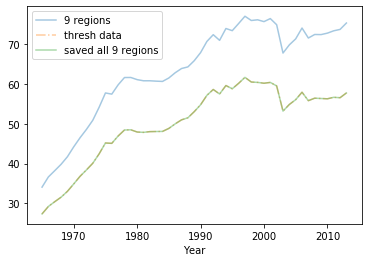

In [8]:
basins['huanghe'].groupby("Year")["Total water use"].sum().plot(label="9 regions", alpha=0.4)
shresh_05_data.groupby("Year")['Total water use'].sum().plot(ls='-.', label='thresh data', alpha=.4)
all_basin_yr = pd.read_csv("../data/perfectures/basins/all_basins.csv")
all_basin_yr = all_basin_yr[all_basin_yr['Basin']=='huanghe'].set_index('Year', )['Total water use']
all_basin_yr.plot(label='saved all 9 regions', alpha=.4)
plt.legend()
plt.show();

可以看到，我们已经将9大流域的数据保存到了文件，其中黄河的数据用的是我们筛选过面积阈值的